# 4 - Feature Construction

## Introduction:

This project will primarily focus on working with categorical data to build new features into the dataset so that the models employed will be able to learn from them. The idea is to introduce and construct features that are useful to improve the model's performance over the baseline.


## Breakdown of this Project:
- Examining the Dataset
- Applying imputation techniques to categorical features.
- Applying encoding techniques to categorical variables.
- Extending numerical features.
- Text-specific feature construction.


## Requirements:



## 1 - Taking a look at the Dataset:

The dataset here will be self-created to show a variety of data leels and types.

In this section, the Pandas Dataframe with its attributes and methods will be used on the dataset.

In [1]:
# Import the Required Libraries:
import pandas as pd

In [2]:
# Set up the Dataset:
X_data = pd.DataFrame({'city':['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'],
                       'boolean':['yes', 'no', None, 'no', 'no', 'yes'], 
                       'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 
                                         'somewhat like', 'dislike'], 
                       'quantitative_column':[1, 11, -.5, 10, None, 20]})

In [3]:
X_data.head()

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN


From the above, the table consists of several columns that are:
- boolen, is a binary categorical data (e.g. yes or no) and this is at the nominal level.
- city, is categorical data and is at the nominal level.
- ordinal_column, is a column of ordinal data and at an ordinal level.
- quantitative_column, contains integers that are at the ratio level.

## 2 - Peform Imputation on the Categorical Features:

With the understanding of the dataset outlined above, this section will go through the imputation process.

### 2.1 - Dealing with Missing Values:

In [4]:
# Find missing values in the dataset:
X_data.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

The output shows that there are 3 missing values in the stated columns. These value will require imputation.

Next, a custom transformer will be implemented, where it is a method that will impute the missing values in a column.

#### For the "City" Column:

As mentioned, this column is categorical, which means the imputation strategy is fill the missing with the most common category.

In [5]:
# Find the most common category in this column:
X_data['city'].value_counts().index[0]

'tokyo'

Here, Tokyo was the most frequent. Next is to impute the missing row.

In [6]:
X_data['city'].fillna(value=X_data['city'].value_counts().index[0])

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

Now that the imputation worked nicely, the next part would be to fix the remaining categorical columns. To do this, a custom imputer will be made.

### 2.2 -  Build Custom Imputer:

Pipeline are an assembly of steps (transformations) that can be cross-validated together while allowing the setting of different parameters.

Building a pipeline allows for the following:
1. Enables the application of sequential list of transformations before a final estimator.
2. Each intermediate steps of the pipeline are "transforms" (a fit and transform method).
3. The last layer is the final Estimator (which is a fit method).

The pipeline will have the built transformers for each of the coloumns that requires imputing, where the dataset will be passed and transformed in one go. 

#### Custom Category Imputer:

Here, the "TransformerMixin" class from scikit-learn will be utlised to build the custom categorical imputer. Note that this transformer is only one of the element in the pipeline, where in this case, it would be dealing with categorical data.

In [7]:
# Import the required library:
from sklearn.base import TransformerMixin

In [8]:
# Define the Custom category imputer Class:

class CustomCategoryImputer(TransformerMixin):
    """ This builds the Custom Category Imputer, that inherits the TransformerMixin class.
        The inheritance should have a .fit_transform method to call with .fit and .transform methods.
    
    """
    # Initialise one instance attribute, the columns:
    def __init__(self, cols=None):
        self.cols = cols
    
    # Fill the missing column values:
    def transform(self, dataFrame):
        X = dataFrame.copy()
        
        for col in self.cols:
            X[col].fillna(value=X[col].value_counts().index[0], inplace=True)
            
        return X
    
    # Fit method, that follows the fit method from scikit-learn:
    def fit(self, *_):
        return self
    

With the above imputer completed, it can be used on the "city" and "boolean" (categorical) columns.

In [9]:
# Apply the custom imputer, instantiate:
cci = CustomCategoryImputer(cols=['city', 'boolean'])

# Fit and transform on the dataset:
cci.fit_transform(X_data)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


The missing values in both columns have now been filled.

### 2.3 - Build Custom Quantitative Imputer:

The Custom Quantitative Imputer will be similar to the previous one, but will contain an added "strategy" parameter that accounts for quantitative data.

In [10]:
# Import the required package:
from sklearn.impute import SimpleImputer

In [11]:
# Define the Custom Quantitative imputer Class:

class CustomQuantitativeImputer(TransformerMixin):
    """ This builds the Custom Quantitative Imputer, that inherits the TransformerMixin class.
        The inheritance should have a .fit_transform method to call with .fit and .transform methods.
    Note:
        - requires SimpleImputer from sklearn.impute .
    """
    # Initialise instance attributes, the columns and a strategy:
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
    
    # Fill the missing column values:
    def transform(self, dataFrame):
        X = dataFrame.copy()
        
        imputer = SimpleImputer(strategy=self.strategy)
        
        # Note the double brackets:
        for col in self.cols:
            X[col] = imputer.fit_transform(X[[col]])
            
        return X
    
    # Fit method, that follows the fit method from scikit-learn:
    def fit(self, *_):
        return self
    

With the above imputer completed, it can be used on the "quantitative_column".

In [12]:
# Apply the custom imputer, instantiate:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')

# Fit and transform on the dataset:
cqi.fit_transform(X_data)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


### 2.4 - Implement Imputers in the Pipeline:

Use both the CustomCategoryImputer and CustomQuantitativeImputer in a pipeline to impute the missing values for both Categorical and Quantitative values.

In [13]:
# Import the required library:
from sklearn.pipeline import Pipeline

In [14]:
# Apply the custom imputer, instantiate:
cci = CustomCategoryImputer(cols=['city', 'boolean'])

# Apply the custom imputer, instantiate:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')

# Pipeline:
pipeline_imputer = Pipeline(steps=[('quant', cqi), 
                                   ('category', cci)] 
                           )

# Fit and transform on the dataset:
pipeline_imputer.fit_transform(X_data)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


## 3 - Applying encoding techniques to categorical variables:

For the compatibility with ML models, categorical values/data will have to be __converted to numerical data__. This is because, ML models all require numerical values to work with.

### 3.1 - Encoding Data at the Nominal Level:

To do this, there are two options to transform the categorical data into dummy variables:
1. Pandas libray is able to find categorical values and dummy code them.
2. Create a custom transformer using dummy variables to work in a pipeline.

__Dummy Variables__: These are 0 or 1 values that indicates the presence of a category. In other words these are proxy variables for qualitative data.

__Dummy Variable Trap__: This is where independent variables are multicollinear or highly correlated, meaning that these variables can be predicted from each other. __To avoid this trap__, is to leave out the constant term or one of the dummy categories. The left out dummy variable can then become the base to be compared with for the rest of the variables.

#### 3.1.1 - Pandas libray is able to find categorical values and dummy code them:

Note that the Ordinal columns should not be dummified.

In [15]:
# Specify the columns to dummify:
pd.get_dummies(data=X_data,
               prefix_sep='_',
               columns= ['city', 'boolean'])

,ordinal_column,quantitative_column,city_london,city_san francisco,city_seattle,city_tokyo,boolean_no,boolean_yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


#### 3.1.2 - Create a custom transformer using dummy variables to work in a pipeline:

Using a custom transformer allows the set up of the pipeline to transform the whole dataset in one go. Note, this mimics the scikit-learn's one-hot encoding method.

In [16]:
class CustomDummifier(TransformerMixin):
    """ This builds the Custom Dummifier, that inherits the TransformerMixin class.
        The inheritance should have a .fit_transform method to call with .fit and .transform methods.
    
    """
    # Initialise one instance attribute, the columns
    def __init__(self, cols=None):
        self.cols = cols
    
    # Transform the dataset with the dummy variables:
    def transform(self, X):
        return pd.get_dummies(data=X,
                              prefix_sep='_',
                              columns= self.cols)
    
    # Fit method, that follows the fit method from scikit-learn:
    def fit(self, *_):
        return self

In [17]:
# Apply the custom Dummifier, instantiate:
cd = CustomDummifier(cols= ['boolean', 'city'])

# Fit and transform on the dataset:
cd.fit_transform(X_data)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,0
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,NaN,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


From the above, it can be seen that the dummy values were applied successfully by the customDummifier class. The next column to consider is the Oridinal Column.

### 3.2 - Encoding Data at the Ordinal Level:

Here, the Oridinal data are in strings, and these will also be needed to be converted to numerical data. At the Ordinal Level, the data have a specific order, therefore the __Label Encoder__ is used to ensure the order is maintained, rather than just using the dummy variables.

The data is processed in such a way that each of the label in the ordinal data will have a numerical value that is associated to it, meaning "labeling" each of the ordinal values uniquely with a numerical value.

In [18]:
# Find the ordering of the Ordinal Values:
ordering = list( X_data['ordinal_column'].unique() )

print(X_data['ordinal_column'].map(lambda x: ordering.index(x)))

0    0
1    1
2    0
3    1
4    0
5    2
Name: ordinal_column, dtype: int64


#### 3.2.1 - Create a custom Label Encoder for Ordinal Variables:

In [19]:
class CustomEncoder(TransformerMixin):
    """ This builds the Custom Label Encoder, that inherits the TransformerMixin class.
        The inheritance should have a .fit_transform method to call with .fit and .transform methods.
    
    """
    # Initialise the instance attributes, the columns and ordering:
    def __init__(self, col=None, ordering=None):
        self.col = col
        self.ordering = ordering
    
    # Transform the dataset's ordinal values:
    def transform(self, dataFrame):
        X = dataFrame.copy()
        
        X[self.col] = X[self.col].map(lambda x: ordering.index(x))
        
        return X
    
    # Fit method, that follows the fit method from scikit-learn:
    def fit(self, *_):
        return self

With the above class implemented, apply it on the ordinal values.

In [20]:
# Find the ordering of the Ordinal Values:
ordering = list( X_data['ordinal_column'].unique() )

# Apply the custom imputer, instantiate:
ce = CustomEncoder(col='ordinal_column', ordering=ordering)

# Fit and transform on the dataset:
ce.fit_transform(X_data)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,0,1.0
1,None,no,1,11.0
2,london,None,0,-0.5
3,seattle,no,1,10.0
4,san francisco,no,0,NaN
5,tokyo,yes,2,20.0


Now, the oridnal values are re-labeled with numerical values.

### 3.3 - Bucketing the Continuous Features into Categories:

Another way of treating continuous numerical features is to bucket them into ranges, transforming a continuous variable into categorical variable.(Examples, age ranges, salary ranges etc.)



In [21]:
# Bining (create a range) the "quatitative_column":
pd.cut(x=X_data['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [22]:
# Bining (create a range) the "quatitative_column", with labels set to false:
pd.cut(x=X_data['quantitative_column'], bins=3, labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

#### 3.3.1 - Create a Custom Cutter for the Continuous Features:

In [23]:
class CustomCutter(TransformerMixin):
    """ This builds the Custom Cutter, that inherits the TransformerMixin class.
        The inheritance should have a .fit_transform method to call with .fit and .transform methods.
    
    """
    # Initialise the instance attributes, the columns, bins and labels:
    def __init__(self, col, bins, labels=False):
        self.col = col
        self.bins = bins
        self.labels = labels
    
    # Transform the dataset's Continuous values:
    def transform(self, dataFrame):
        X = dataFrame.copy()
        
        X[self.col] = pd.cut(x=X[self.col], bins=self.bins, labels=self.labels)
        
        return X
    
    # Fit method, that follows the fit method from scikit-learn:
    def fit(self, *_):
        return self

In [24]:
# Apply the custom Cutter, instantiate:
cc = CustomCutter(col='quantitative_column', bins=3, labels=False)

# Fit and transform on the dataset:
cc.fit_transform(X_data)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0.0
1,None,no,like,1.0
2,london,None,somewhat like,0.0
3,seattle,no,like,1.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,2.0


Now, the Continuous Variables in the "quantitative_column" have been imputed into its respective bins. \
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

## 4 - Create the Pipeline:

This section will transform the dataset accordingly with the above mentioned imputation classes, where it will convert the values into ML model ready numerical values. It will do this will a Pipeline Implementation.

The sequence of the Pipeline:
1. Impute the Missing Values
2. Dummify the categorical columns.
3. Encode the Ordinal column.
3. Bucketise the Quatitative column.

In [25]:
# ==============================================================================

# Apply the custom imputer, instantiate:
cci = CustomCategoryImputer(cols=['city', 'boolean'])

# Apply the custom imputer, instantiate:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')

# Define the imputer: for quantitative and categorical values.
imputer = Pipeline(steps=[('quant', cqi),
                          ('category', cci)]
                  )
# ==============================================================================

# Apply the custom dummifier, instantiate:
cd = CustomDummifier(cols= ['boolean', 'city'])

# ==============================================================================

# Find the ordering of the Ordinal Values:
ordering = list( X_data['ordinal_column'].unique() )

# Apply the custom imputer, instantiate:
ce = CustomEncoder(col='ordinal_column', ordering=ordering)

# ==============================================================================

# Apply the custom Cutter, instantiate:
cc = CustomCutter(col='quantitative_column', bins=3, labels=False)

# ==============================================================================



In [26]:
# Define the Pipeline Sequence:
pipe = Pipeline(steps=[("imputer", imputer), 
                       ("dummify", cd), 
                       ("encode", ce), 
                       ("cut", cc)]
               )

# Fit the Pipeline to the Dataset:
pipe.fit(X_data)

# Transform the Dataset:
pipe.transform(X_data)




,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,0,0,0,1,0,0,0,1
1,1,1,1,0,0,0,0,1
2,0,0,1,0,1,0,0,0
3,1,1,1,0,0,0,1,0
4,0,1,1,0,0,1,0,0
5,2,2,0,1,0,0,0,1


Great, all the values in the dataset are now in Numerical form, which is compatible with ML models.

## 5 - Extending numerical features:

For numerical features, it is also to create extended features by undergoing through vaarious methods. Here a new dataset will be utilised to demonstrate the process. 

### 5.1 - Dataset: Activity recognition from a Single Chest Mounted Accelerometer dataset.

Link: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer

Dataset Description: It is a collection of data from a wearable accelerometer that is mounted on the chest of 15 subjects. These subjects performs 7 activities and the accelerometer records the activity data. The sampling frequency of the accelerometer is set to 52Hz and is presented to be uncalibrated.

Attribute Information:
- Data are separated by participant
- Each file contains the following information:
    1. sequential number, 
    2. x acceleration, 
    3. y acceleration, 
    4. z acceleration, 
    5. label

Labels are codified by numbers:
1. Working at Computer
2. Standing Up, Walking and Going updown stairs
3. Standing
4. Walking
5. Going UpDown Stairs
6. Walking and Talking with Someone
7. Talking while Standing

### 5.2 - Load in the Dataset:

In [27]:
import os

In [28]:
# Set up the Working Directory:
currentDirectory = os.getcwd()

# Path to Dataset:
path_dataset = currentDirectory + '/Dataset/Activity Recognition_Accelerometer Dataset/'

# Read in the dataset:
accelerometer_dataset = pd.read_csv(path_dataset + 'Accelerometer Dataset.csv', sep=',', header=None)

In [29]:
# Inspect:
accelerometer_dataset.head()

,0,1,2,3,4
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


It can be seen that there are no column header, so let's add in those now, according to the scheme.

In [30]:
# Define the column headers:
dat_column_headers = ['index', 'x', 'y', 'z', 'activity']

# Set it up:
accelerometer_dataset.columns = dat_column_headers

# Inspect:
accelerometer_dataset.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


Note that the target variable here is the "activity" column. This is the "y" variable that the model should predict.

### 5.3 - Determine the Null Accuracy of the ML Model:

To do this, invoke the "value_counts()" method with the "normalize" parameter set to true. The largest output value here will be the Null Accuracy value.

In [31]:
accelerometer_dataset['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

The Null accuracy value is 51.53%.

### 5.4 - Determine the Base ML model Accuracy:

The accuracy result from the model here will be used as the benchmark moving forward. The model to be used here is the: KNN model.

In [32]:
# Import the required Libraries:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#### 5.4.1 - Split the dataset into Training and Testing sets:

In [33]:
# Define the Training Set:
X = accelerometer_dataset[['x', 'y', 'z']]

# Define the Testing Set:
y = accelerometer_dataset['activity']


#### 5.4.2 - Sett up the Grid Search Parameters for the model:

In [34]:
# KNN Parameters to Grid Search:
knn_params = {'n_neighbors': [3, 4, 5, 6, 7, 8]}

#### 5.4.3 - Run the KNN Model and Evaluate the results:

In [35]:
# Instantiate the model:
knn = KNeighborsClassifier()

# Grid Search:
grid = GridSearchCV(estimator=knn, param_grid=knn_params, n_jobs=-1)

# Fit the model to the dataset:
grid.fit(X, y)

# Print the results:
print("Model's Best Score: {}% and Best Parameters: {}".format( (100 * grid.best_score_) , grid.best_params_))


D:\anaconda3\envs\Py37Work\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Model's Best Score: 74.81678310489855% and Best Parameters: {'n_neighbors': 7}


The accuracy score to beat has been determined to be 74.8%.

## 6 - Polynomial Features:

An important key point to working with numerical data and the creation of more features from it, would be to utilised the "PolynomialFeatures" class from scikit-learn. It essentially is a constructor thatt creates new columns that are products of existing columns in the dataset, it captures the feature interactions.

Specifically, it will generate a new feature matrix by utilising all of the polynomial combinations of the features with a degress less than or equal to a specified degree. This means that for the example, if the input sample is 2-Dimensional, like [a, b], then the degree-2 polynomial features will be [1, a, b, a^2, ab, b^2]

The "PolynomialFeatures" class have 3 parameters:
1. degree, is the degree of the polynomial features (default = 2)
2. interaction_only, is a Boolean, if True outputs only the interaction features. This means the output feattures are products of degree distinct features. (default = False)
3. include_bias, is a Boolean, if True will include a Bias column. This means the feature where all polynomial powers are zero, adding a column of all ones. 

### 6.1 - Set up the Polynomial Feature instance:

In [36]:
# Import the required library:
from sklearn.preprocessing import PolynomialFeatures

In [37]:
# Instantiate:
poly = PolynomialFeatures(degree=2,
                          interaction_only=False,
                          include_bias=False)

# Fit and Transform on the dataset:
X_polynomial = poly.fit_transform(X)

# Inspect:
X_polynomial.shape

(162501, 9)

In [38]:
# Convert to DataFrame and Inspect:
X_polynomial_df = pd.DataFrame(data=X_polynomial, columns=poly.get_feature_names())
X_polynomial_df.head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


## 7 - Exploratory Data Analysis (EDA):

With the polynomial features established, this section will go into visualising the dataset to better guage the interactions of the features.

In [39]:
# Import the required Library:
%matplotlib inline
import seaborn as sns

### 7.1 - Heatmap:

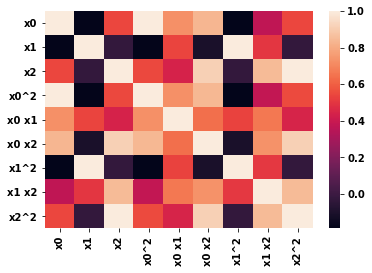

In [40]:
sns.heatmap(data=X_polynomial_df.corr())

From the above heatmap, the colour that is lighter means the greater the correlation between these features.

### 7.2 - Parameter change: set interaction_only to True

In [41]:
# Instantiate:
poly = PolynomialFeatures(degree=2,
                          interaction_only=True,
                          include_bias=False)

# Fit and Transform on the dataset:
X_polynomial = poly.fit_transform(X)

# Inspect:
X_polynomial.shape

(162501, 6)

In [42]:
# Convert to DataFrame and Inspect:
X_polynomial_df = pd.DataFrame(data=X_polynomial, columns=poly.get_feature_names())
X_polynomial_df.head()

,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


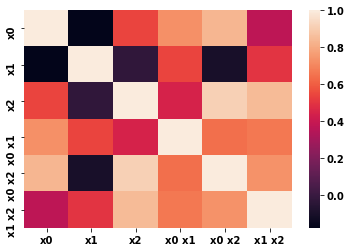

In [43]:
# Heatmap:
sns.heatmap(data=X_polynomial_df.corr())

The number of columns have been reduced from 9 to 6, which subsequently produced the heatmap above. These are the features that interact with each other.

### 7.3 - Run the KNN model with these new features:

#### Set up the Grid Search Parameters for the model:

In [44]:
# KNN Parameters to Grid Search:
pipe_params = {'poly_features__degree': [1, 2, 3, 4, 5],
               'poly_features__interaction_only': [True, False],
               'classify__n_neighbors': [3, 4, 5, 6, 7, 8]}

#### Set up the Pipeline:

In [45]:
pipe = Pipeline([('poly_features', poly), ('classify', knn)])

#### Run the KNN Model and Evaluate the results:

In [46]:
# Grid Search:
grid = GridSearchCV(estimator=pipe, param_grid=pipe_params, n_jobs=-1)
# grid = GridSearchCV(pipe, pipe_params, n_jobs=-1)
# Fit the model to the dataset:
grid.fit(X, y)

# Print the results:
print("Model's Best Score: {}% and Best Parameters: {}".format( round((100 * grid.best_score_), ndigits=2) , grid.best_params_))


D:\anaconda3\envs\Py37Work\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Model's Best Score: 74.82% and Best Parameters: {'classify__n_neighbors': 7, 'poly_features__degree': 2, 'poly_features__interaction_only': False}


The benchmarked accuracy before was 74.8%. The model with polynomial features was able to achieve 74.82%, this can be seen to be only a slight improvement. 

## 8 - Text-specific Feature Construction:

From this point on, the categorical data will be in the form of __Strings__. This kind of data is much more complex, as the dataset will be a series of categories (a.k.a tokens).

This type of work would be called __Natural Language Processing (NLP)__. As mentioned before, all ML models will require the input to be in numerical values, therefore there are techniques to convert text data into numerical features.

### 8.1 - Dataset:

Link: http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

Dataset Description:

The Twitter Sentiment Analysis Dataset contains 1,578,627 classified tweets, each row is marked as 1 for positive sentiment and 0 for negative sentiment.

### 8.2 - Bag of Words Representation:

Scikit-learn does have a module that is the "feature_extraction" to extract features from text data. From here on out, the text data will be refered to as "Corpus", which means the aggregate of text content or documents.

A vectorisation technique called "__Bag-og-words__" allows for the transformation of a corpus into numerical representations. It finds the occuences of words while ignoring the positioning of the words in the document. 

A Bag-of-words is achieved with 3 steps:
1. Tokenising, it uses white spaces and punctuation to separate the words from each other and turns them in tokens, where each possible token has an iteger ID.
2. Counting, countts the occurrences of the tokens within the document.
3. Normalising, the tokens are then weighted with diminishing importance when they occur in the majority of the documents.

There are also 2 more:
1. CountVectorizer.
2. TF-idf vectorizer.


### 8.3 - CountVectorizer:

This is one of the most commonly used method to convert text data into vector representations. It converts the text columns into matrices, whereby the columns are ttoken and the cell values are counts of occurrences. The resultant matrix is called "document-term matrix".

### 8.3.1 - CountVectorizer Parameters:

The parameters are:
- stop_words, set to "English" to use the built-in list of stop words. Removes stop words (Unwanted Noise) from the tokens.
- min_df, to skim the number of features by ignoring less frequent terms of a given threshold.
- max_df, to include only words that occur the most, set by a given threshold.
- ngram_range, takes in a tuple of [lower, upper] boundary of the range of n-values, this indicates the number of different n-grams to be extracted. N-grams represent Phrases.
- analyzer, determines if the feautre should be made of word or character n-grams.

## 8.4 - Load in the Dataset:

In [47]:
# Set up the Working Directory:
currentDirectory = os.getcwd()

# Path to Dataset:
path_dataset = currentDirectory + '/Dataset/Tweets Dataset/'

# Read in the dataset:
tweets_data_df = pd.read_csv(path_dataset + 'twitter_sentiment.csv', encoding='latin1')


In [48]:
# Inspect:
tweets_data_df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [49]:
# Remove the first column: ItemID
del tweets_data_df['ItemID']


### 8.5 - Perform the Feature Extraction: with CountVectorizer

In [50]:
# Import the required library:
from sklearn.feature_extraction.text import CountVectorizer

#### Split the dataset into X and Y: 

X for the training data and Y for the target variable.

In [51]:
# Split:
X_tweets = tweets_data_df['SentimentText']

y_tweets = tweets_data_df['Sentiment']

# Inpect the shape:
X_tweets.shape

(99989,)

In [52]:
# Instantiate the CountVectorizer:
vect = CountVectorizer()

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 105849)


There are now 105,849 columns, whereas there was none in the original dataset.

### 8.5.1 - Stop Words:

Stop words are the Noise in a text dataset, where they are commonly used words in the specified language, like if, a, the and so on. (https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html)

In [53]:
# Instantiate the CountVectorizer: with stop words
vect = CountVectorizer(stop_words='english')

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 105545)


There are now 105,545 columns.

### 8.5.2 - min_df:

This will only include (min_df=0.05) words that occur in at least 5% of the corpus documents.

In [54]:
# Instantiate the CountVectorizer: with min_df
vect = CountVectorizer(min_df=0.05)

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 31)


### 8.5.3 - max_df:

This will only include (max_df=0.8) words that occur in at most 80% of the corpus documents.

In [55]:
# Instantiate the CountVectorizer: with max_df
vect = CountVectorizer(max_df= 0.80)

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 105849)


### 8.5.4 - ngram_range:

Inclues phrases up to 5 words.

In [56]:
# Instantiate the CountVectorizer: with  ngram_range
vect = CountVectorizer(ngram_range= (1, 5))

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 3219557)


### 8.5.5 -  Have a look at the feature names:

In [57]:
vect.get_feature_names()[:15]

['00',
 '00 01',
 '00 01 minute',
 '00 01 minute after',
 '00 01 minute after applications',
 '00 10',
 '00 10 00',
 '00 56',
 '00 56 03',
 '00 56 03 beating',
 '00 56 03 beating my',
 '00 always',
 '00 always have',
 '00 always have such',
 '00 always have such warmth']

### 8.5.6 - lowercase:

Changes all the text data to lowercase.

In [58]:
# Instantiate the CountVectorizer: with lowercase
vect = CountVectorizer(lowercase=True)

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 105849)


### 8.5.7 - max_features:

Places hard limits on the features based on max counts.

In [59]:
# Instantiate the CountVectorizer: with max_features
vect = CountVectorizer(max_features=1000)

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 1000)


### 8.5.8 - analyzer:

For analyzer='word': By using the default (word) analyzer, it will split the corpus into words.
For analyzer='char': Uses the characters.
For analyzer='char_wb': Here, it uses characters again but only those are aren't at the beginning or ends of words wb stands for word boudnaries.

In [60]:
# Instantiate the CountVectorizer: with analyzer
vect = CountVectorizer(analyzer='word')

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 105849)


In [61]:
vect.get_feature_names()[:10]

['00',
 '000',
 '0001t',
 '000martha',
 '001',
 '0010x0010',
 '0022',
 '007',
 '007heather007',
 '007hil']

In [62]:
# Instantiate the CountVectorizer: with analyzer
vect = CountVectorizer(analyzer='char')

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 153)


In [63]:
vect.get_feature_names()[:10]

['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'"]

In [64]:
# Instantiate the CountVectorizer: with analyzer
vect = CountVectorizer(analyzer='char_wb')

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 149)


In [65]:
vect.get_feature_names()[:10]

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')']

## 8.6 - Building a Custom Analyzer:

From a concept perspective, words are built from root words (a.k.a stems) and from these, a custom analyzer can be built.

__Stemming__ is a common NLP method that allows for the stemming of vocabulary, meaning it is made smaller by converting the words into its roots. A great toolkit to do this is __NLTK__ package, and another is the __Stemmer__ package.

In [66]:
# Import the required libraries:
from nltk.stem.snowball import SnowballStemmer

In [67]:
# Instantiate:
stemmer = SnowballStemmer(language='english')

In [68]:
# Example of stemming:
stemmer.stem('interesting'), stemmer.stem('interesting') == stemmer.stem('interest')

('interest', True)

### 8.6.1 - Create a function that allows for tokenising words into their stems:

In [69]:
# Define a function that accepts text and returns a list of lemmas:
def word_tokenise(text, how='lemma'):
    
    # tokenise into words:
    words = text.split(' ')
    
    return [stemmer.stem(word) for word in words]

In [70]:
# Test it:
word_tokenise("hello you are very interesting")

['hello', 'you', 'are', 'veri', 'interest']

In [71]:
# Apply it as a custom analyser: custom
# Instantiate the CountVectorizer: with analyzer
vect = CountVectorizer(analyzer=word_tokenise)

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape)

(99989, 154397)


As it can be seen, CountVectorizer is useful in expanding the features and at the same time, converts the text into numerical features.

## 8.7 - Tf-idf Vectorizer: Term Frequency-Inverse Document Frequency

Tf–idf stands for "Term Frequency–Inverse Document Frequency" is a numerical statistic used to reflect how important a word is to a document in a collection or corpus of documents. TFIDF is used as a weighting factor during text search processes and text mining.

- Intuition: if a word appears several times in a given document, this word might be meaningful (more important) than other words that appeared fewer times in the same document. However, if a given word appeared several times in a given document but also appeared many times in other documents, there is a probability that this word might be common frequent word such as 'I' 'am'..etc. (not really important or meaningful!).

- TF: Term Frequency is used to measure the frequency of term occurrence in a document: TF(word) = Number of times the 'word' appears in a document / Total number of terms in the document

- IDF: Inverse Document Frequency is used to measure how important a term is: IDF(word) = log_e(Total number of documents / Number of documents with the term 'word' in it).

__For Example__: 

Let's assume we have a document that contains 1000 words and the term “John” appeared 20 times, the Term-Frequency for the word 'John' can be calculated as follows: -> TF | john = 20/1000 = 0.02

Let's calculate the IDF (inverse document frequency) of the word 'john' assuming that it appears 50,000 times in a 1,000,000 million documents (corpus). -> IDF | john = log (1,000,000/50,000) = 1.3

Therefore the overall weight of the word 'john' is as follows -> TF-IDF | john = 0.02 * 1.3 = 0.026



In [72]:
# Import the required Libraries:
from sklearn.feature_extraction.text import TfidfVectorizer

#### For Default CountVectorizer():

In [73]:
# Instantiate the CountVectorizer: with defaults
vect = CountVectorizer()

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape, _[0, :].mean())

(99989, 105849) 6.613194267305311e-05


#### With TfidfVectorizer():

In [74]:
# Instantiate the TfidfVectorizer: with defaults
vect = TfidfVectorizer()

# Fit and transform on the dataset with CountVectorizer:
_ = vect .fit_transform(X_tweets)

# Inspect the Shape of the output:
print(_.shape, _[0, :].mean())

(99989, 105849) 2.1863060975751192e-05


From the output above, both vectorisers do output the same number of rows and columns, however, the values in each cell is different. This is because, the way in which the cells are filled is different.

## 9 - Machine Learning Pipelines with Text:

Recall that the goal is to convert text data into numerical values that would be acceptable by ML models. Both thhe CountVectorizer and TfidVectorizer are "transformers", this means that it will work well with scikit-learn's pipeline. 

The classifier employed here will be the __Naive Bayes__ Model. 

In [75]:
# Import the required Libraries:
from sklearn.naive_bayes import MultinomialNB

### 9.1 - Define the NULL accuracry: 

For the purposes of comparison.

In [76]:
# Null Accuracy:
y_tweets.value_counts(normalize=True)

1    0.564632
0    0.435368
Name: Sentiment, dtype: float64

From the above output, the null accuracy here is 56.46%.

### 9.2 - Build the Pipeline:

The sequence for this pipeline will be:
1. CountVectorizer() to be used to featureise the tweets (text data).
2. MultiNomialNB(), is the Naive Bayes model that will perform the classification task to output a positive or negative sentiment (sentiment anaylsis classification task).

In [77]:
# Definte the Pipeline Parameters:
pipe_params = {'vect__ngram_range': [(1, 1), (1, 2)],
               'vect__max_features': [1000, 10000],
               'vect__stop_words': [None, 'english']
              }

In [78]:
# Instantiate the Pipeline:
pipe_tweets = Pipeline(steps=[('vect', CountVectorizer()),
                              ('classify', MultinomialNB())
                             ]
                      )

# Instantiate the GridSearvhCV object:
grid = GridSearchCV(estimator=pipe_tweets, param_grid=pipe_params, n_jobs=-1)

# Fit the grid search to the dataset:
grid.fit(X_tweets, y_tweets)

# Print the results:
print("Model's Best Score: {}% and Best Parameters: {}".format( round((100 * grid.best_score_), ndigits=2) , grid.best_params_))


Model's Best Score: 75.59% and Best Parameters: {'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}


## 9.3 - Horizontal Stacking of Features:

Rather than rebuilding the pipeline with tfidVectorizer(), this section will demonstrate the use of the "FeatureUnion" module from sklearn. It supports the horizontal stacking of features, meaning the features are placed side by side. More importantly, it allows the use of multiple types of text featurisers within the same pipeline.

In [79]:
# Import the required libraries:
from sklearn.pipeline import FeatureUnion

In [80]:
# Build the Featuriser Object:
featuriser = FeatureUnion(transformer_list=[('tfidf_vect', TfidfVectorizer()),
                                            ('count_vect', CountVectorizer())],
                          n_jobs=-1
                         )

# Fit and transform on the dataset:
_ = featuriser.fit_transform(X_tweets)

# Inspect:
print(_.shape)

(99989, 211698)


It shows twice as many columns, as a result of the "side-by-side" data in the cells. This allows the ML model to learn from __BOTH__ sets of data at the same time.

### 9.3.1 - Change the parameters of the Featuriser:

In [81]:
# Change the parameters:
featuriser.set_params(tfidf_vect__max_features=100, 
                      count_vect__ngram_range=(1, 2), 
                      count_vect__max_features=300)

# Fit and transform on the dataset:
_ = featuriser.fit_transform(X_tweets)

# Inspect:
print(_.shape)

(99989, 400)


### 9.3.2 - Build a more Comprehensive Pipeline and Classify:

In [82]:
import timeit

In [83]:
# running time calculation
start = timeit.default_timer()

In [84]:
# Define the Pipeline Parameters:
pipe_params = {'featuriser__count_vect__ngram_range':[(1, 1), (1, 2)], 
               'featuriser__count_vect__max_features':[1000, 10000], 
               'featuriser__count_vect__stop_words':[None, 'english'],
              'featuriser__tfidf_vect__ngram_range':[(1, 1), (1, 2)], 
               'featuriser__tfidf_vect__max_features':[1000, 10000], 
               'featuriser__tfidf_vect__stop_words':[None, 'english']}

# Instantiate the Pipeline:
pipe_tweets = Pipeline(steps=[('featuriser', featuriser),
                              ('classify', MultinomialNB())
                             ]
                      )

# Instantiate the GridSearvhCV object:
grid = GridSearchCV(estimator=pipe_tweets, param_grid=pipe_params, n_jobs=-1)

# Fit the grid search to the dataset:
grid.fit(X_tweets, y_tweets)

# Print the results:
print("Model's Best Score: {}% and Best Parameters: {}".format( round((100 * grid.best_score_), ndigits=2) , grid.best_params_))


Model's Best Score: 75.81% and Best Parameters: {'featuriser__count_vect__max_features': 10000, 'featuriser__count_vect__ngram_range': (1, 2), 'featuriser__count_vect__stop_words': None, 'featuriser__tfidf_vect__max_features': 10000, 'featuriser__tfidf_vect__ngram_range': (1, 1), 'featuriser__tfidf_vect__stop_words': 'english'}


In [85]:
# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

Time: 2.78 Minutes
Time: 0.05 hours


### Conclusion:

The model only increase slightly in its accuracy (by 0.20%) from learning with bothh datasets.

## Summary:

This project has allowed me to learn a great deal about implementing classes that deals with features in the form of categorical, numerical and text into ML model compatible numerical values. These classes are useful as it is compatible with the sklearn library and its models, where I also learn how to implement them in a Pipeline where it helps to streamline the entire process. 